# SpamData_BetaBinomialNaiveBayes_Classifier
Author: Xin Zhengfang

## Data Preprocessing
   The data is an email spam dataset, and the dataset description can be found [in this link 425](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.info.txt)

In [1]:
import scipy.io as sio
import numpy as np

In [2]:
# Load .mat file into numpy array[https://stackoverflow.com/questions/874461/read-mat-files-in-python]
mat_contents = sio.loadmat('spamData.mat')
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtrain', 'Xtest', 'ytrain', 'ytest'])

In [3]:
#  Convert to arrary
Xtrain = mat_contents['Xtrain']
Xtest = mat_contents['Xtest']
ytrain = mat_contents['ytrain']
ytest = mat_contents['ytest']
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(3065, 57) (1536, 57) (3065, 1) (1536, 1)


In [4]:
# Data preprocessing

# binarization:
bin_Xtrain = (Xtrain > np.median(Xtrain)).astype('int')
bin_Xtest = (Xtest > np.median(Xtest)).astype('int')

## Beta-binomial Naive Bayes
**The class labels:**
1. The class labels' $\lambda$ is estimated using ML(maxmum likelihodd).
2. $\lambda^{M L}$ is used as the plug-in estimator for testing

**The features distribution:**
1. A $\operatorname{Beta}(\alpha, \alpha)$ prior is assumed on the features distribution.
2. The error rate is evaluated with $\alpha=\{0,0.5,1,1.5,2, \cdots, 100\}$ on the test data.
3. The Bayesian(i.e., posterior predictive) is used on training and testing.

**Posterior Predictive Distribution with $\operatorname{Beta}(a, b)$ prior:**
$$
\begin{aligned} p(\tilde{x}=1 | D) &=\int_{0}^{1} p(\tilde{x}=1, \theta | D) d \theta=\int_{0}^{1} p(\tilde{x}=1 | \theta, D) p(\theta | D) d \theta \\ &=\int_{0}^{1} p(\tilde{x}=1 | \theta) p(\theta | D) d \theta=\int_{0}^{1} \theta p(\theta | D) d \theta \\ &=E(\theta | D)=\frac{N_{1}+a}{N+a+b} \end{aligned}
$$
**Maxmum likelihood for the class labels with binomial:**
$$
\hat{\theta}_{M L}=\frac{N_{1}}{N} \text { by setting } \mathrm{a}=\mathrm{b}=1 \text { (uniform prior) }
$$
Note: the Beta-binomial model basics can be found in Machine_Learning_AXIN_Probabilistic_Perspec(KM)-CHAPTER 3.3

In [5]:
# Trainning ★
'''
    To get lambda_ML, eta_jc_MAP lists
'''
lambda_ML = []
alp_eta = []
num_features = Xtrain.shape[-1]
# Pr(y = 1 | lambda_ML)
lambda_ML = np.sum(ytrain)/np.sum(np.ones(ytrain.shape))

# For each feature
for a in range(201):
    eta_jc = [[],[]]
    for j in range(num_features):
        c1_mask = ytrain.repeat(num_features,-1)
        c0_mask = 1 - c1_mask
        c0_bin_Xtrain = c0_mask*bin_Xtrain
        c1_bin_Xtrain = c1_mask*bin_Xtrain
        # Pr(x_j = 1 | y = 0, eta_j0) = eta_j0
        eta_jc[0].append((np.sum(c0_bin_Xtrain[:,j])+0.5*a)/(np.sum(1-ytrain)+0.5*a*2))
        # Pr(x_j = 1 | y = 1, eta_j1) = eta_j1
        eta_jc[1].append((np.sum(c1_bin_Xtrain[:,j])+0.5*a)/(np.sum(ytrain)+0.5*a*2))
    alp_eta.append(eta_jc)
alp_eta = np.array(alp_eta)

In [6]:
# Predict
def BNB_pred(bin_features,lam,eta):
    '''
    Input: 
        bin_feaxtures #feaztures of the sampfle
        lam, eta #params of Beta-binomial Naive Bayes model
    Output: 
        pred #predicted label
    '''
    x0_mask = 1 - bin_features
    c0_eta_fix = bin_features*eta[0] + x0_mask*(1-eta[0])
    c1_eta_fix = bin_features*eta[1] + x0_mask*(1-eta[1])
    pr_c0 = (1-lam)*np.prod(c0_eta_fix)
    pr_c1 = lam*np.prod(c1_eta_fix)
    if pr_c0 > pr_c1:
        pred = 0
    else:
        pred = 1
    return pred

In [7]:
# Xtrain_pred respecting with alpha
alp_Xtrain_pred = []
for a in range(201):
    Xtrain_pred = []
    for spl in bin_Xtrain:
        Xtrain_pred.append(BNB_pred(spl,lambda_ML,alp_eta[a]))
    alp_Xtrain_pred.append(Xtrain_pred)

In [8]:
# Xtest_pred respecting with alpha
alp_Xtest_pred = []
for a in range(201):
    Xtest_pred = []
    for spl in bin_Xtest:
        Xtest_pred.append(BNB_pred(spl,lambda_ML,alp_eta[a]))
    alp_Xtest_pred.append(Xtest_pred)

In [9]:
print(np.array(alp_Xtrain_pred).shape)
print(np.array(alp_Xtest_pred).shape)

(201, 3065)
(201, 1536)


In [10]:
mask_ytrain = ytrain.transpose(-1,0).repeat(201,0)
mask_ytest = ytest.transpose(-1,0).repeat(201,0)
alp_Xtrain_err = 1 - np.sum((alp_Xtrain_pred == mask_ytrain).astype('int'),-1)/np.array(alp_Xtrain_pred).shape[-1]
alp_Xtest_err = 1 - np.sum((alp_Xtest_pred == mask_ytest).astype('int'),-1)/np.array(alp_Xtest_pred).shape[-1]

### Plots of training and test error rates versus $\alpha$

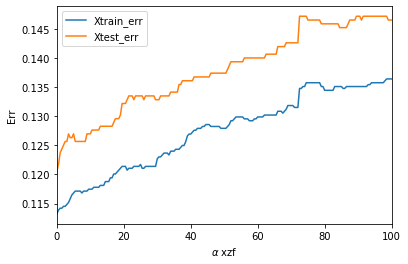

In [12]:
import matplotlib.pyplot as plt

plt.plot([0.5*i for i in range(201)], alp_Xtrain_err)
plt.plot([0.5*i for i in range(201)], alp_Xtest_err)
plt.xlim(0,100)
plt.legend(['Xtrain_err', 'Xtest_err'], loc='upper left')
plt.xlabel('$\\alpha$ xzf')
plt.ylabel('Err')
plt.show()

### What do you observe about the training and test errors as $\alpha$ change?
As $\alpha$ increases, the training and test error_rate are both tend to increase.

### Training and testing error rates for $\alpha$ = 1, 10 and 100.

In [13]:
print("Training error rates:")
print("\t \u03B1=1  ",alp_Xtrain_err[2])
print("\t \u03B1=10 ",alp_Xtrain_err[20])
print("\t \u03B1=100",alp_Xtrain_err[200])
print("Testing error rates:")
print("\t \u03B1=1  ",alp_Xtest_err[2])
print("\t \u03B1=10 ",alp_Xtest_err[20])
print("\t \u03B1=100",alp_Xtest_err[200])

Training error rates:
	 α=1   0.11419249592169656
	 α=10  0.1174551386623165
	 α=100 0.13637846655791186
Testing error rates:
	 α=1   0.12369791666666663
	 α=10  0.126953125
	 α=100 0.146484375


In [14]:
# Algorithm Test
toy_Xtrain = np.array([[1,0],[1,1],[0,0]])
toy_Xtest = np.array([[1,0]])
toy_ytrain = np.array([[1],[1],[0]])
toy_ytest = np.array([[1]])

lambda_ML = []
alp_eta = []
num_features = toy_Xtrain.shape[-1]

lambda_ML = np.sum(toy_ytrain)/np.sum(np.ones(toy_ytrain.shape))

# For each feature
for a in range(201):
    eta_jc = [[],[]]
    for j in range(num_features):
        c1_mask = toy_ytrain.repeat(num_features,-1)
        c0_mask = 1 - c1_mask
        c0_toy_Xtrain = c0_mask*toy_Xtrain
        c1_toy_Xtrain = c1_mask*toy_Xtrain
        # Pr(x_j = 1 | y = 0, eta_j0)
        eta_jc[0].append((np.sum(c0_toy_Xtrain[:,j])+0.5*a)/(np.sum(1-toy_ytrain)+0.5*a*2))
        # Pr(x_j = 1 | y = 1, eta_j1)
        eta_jc[1].append((np.sum(c1_toy_Xtrain[:,j])+0.5*a)/(np.sum(toy_ytrain)+0.5*a*2))
    alp_eta.append(eta_jc)
alp_eta = np.array(alp_eta)

In [15]:
print(lambda_ML,"\n",alp_eta[4]) # Right!

0.6666666666666666 
 [[0.4        0.4       ]
 [0.66666667 0.5       ]]


In [16]:
print(toy_Xtest,'\n')
x0_mask = 1 - toy_Xtest
c0_eta_fix = toy_Xtest*alp_eta[4][0] + x0_mask*(1-alp_eta[4][0])
c1_eta_fix = toy_Xtest*alp_eta[4][1] + x0_mask*(1-alp_eta[4][1])
log_pr_c0 = np.log((1-lambda_ML)*np.prod(c0_eta_fix))
log_pr_c1 = np.log(lambda_ML*np.prod(c1_eta_fix))
if log_pr_c0 > log_pr_c1:
    pred = 0
else:
    pred = 1
print("log_pr_c0",log_pr_c0)
print("log_pr_c1",log_pr_c1)
print(pred)

[[1 0]] 

log_pr_c0 -2.5257286443082556
log_pr_c1 -1.5040773967762742
1


In [17]:
# Correct Answer!!